In [1]:
from models_pompAgg import init_modelV, modelV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
def checkbound_state_vars(x_state_ens, pop, num_params=8, num_ensembles=300):
    loww = 0
    upp  = pop
    x_state_ens = np.clip(x_state_ens, 0, upp)
    return x_state_ens



In [3]:
samples = np.load("../results/samples_aggV_Final2_360.npz")
param_prior = samples['param_posterior']
betas = np.mean(np.mean(param_prior.copy()[0,:,:,:],-1),0)
alpha_ss = np.mean(np.mean(param_prior.copy()[1,:,:,:],-1),0)
Vr_ss = np.mean(param_prior.copy()[2,:,:,:],-1)

In [5]:
date_init  = pd.to_datetime("2021-02-15")
date_end   = pd.to_datetime("2021-10-26")
dates      = pd.date_range(start=date_init, end=date_end, freq='1D')
num_steps = len(dates)
df_all    = []
num_iters = 10
num_var = 16
num_ensembles = 200
df_all = np.zeros((num_var, num_ensembles, num_steps, num_iters))
from tqdm import tqdm
for idx_iter in tqdm(range(num_iters)):
    
    population         = 40000000.0
    x                  = init_modelV(pop = population, num_variables=num_var, num_ensembles=num_ensembles)
    ifr   = 0.024749977542727945
    iVfr  = 0.0808581766320922

    x_all = np.zeros((num_var, num_ensembles, num_steps))
    x_all[:,:,0]=x
    for t in range(1,num_steps):
        beta = np.mean(betas)
        alpha_s = np.mean(alpha_ss)
        Vr = Vr_ss[:,t]
        x_ens =(modelV(x=x_all[:,:,t-1], beta=beta, ifr = ifr, alpha=alpha_s, iVfr=iVfr, Vr = Vr, N=population, num_ensembles=10))
        
        
        x_ens1 = checkbound_state_vars(x_state_ens=x_ens, pop=population, num_params= num_var, num_ensembles= num_ensembles)
        
        x_all[:,:,t]=x_ens1
    
    df_all[:,:,:,idx_iter]=x_all

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.03it/s]


In [6]:
def create_df_response(samples, time, date_init ='2020-03-06',  quantiles = [50, 80, 95], forecast_horizon=27, dates=None, use_future=False):
    """[summary]

    Args:
        samples ([type]): [description]
        time ([type]): [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """
    if dates is not None:
        dates_fitted = dates
    else:
        dates_fitted   = pd.date_range(start=pd.to_datetime(date_init), periods=time)
        dates_forecast = pd.date_range(start=dates_fitted[-1]+datetime.timedelta(1), periods=forecast_horizon)

    dates = list(dates_fitted)
    types = ['estimate']*len(dates_fitted)
    if use_future:
        dates += list(dates_forecast)
        types  += ['forecast']*len(dates_forecast)

    results_df = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)
    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q

        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'
    return df_response

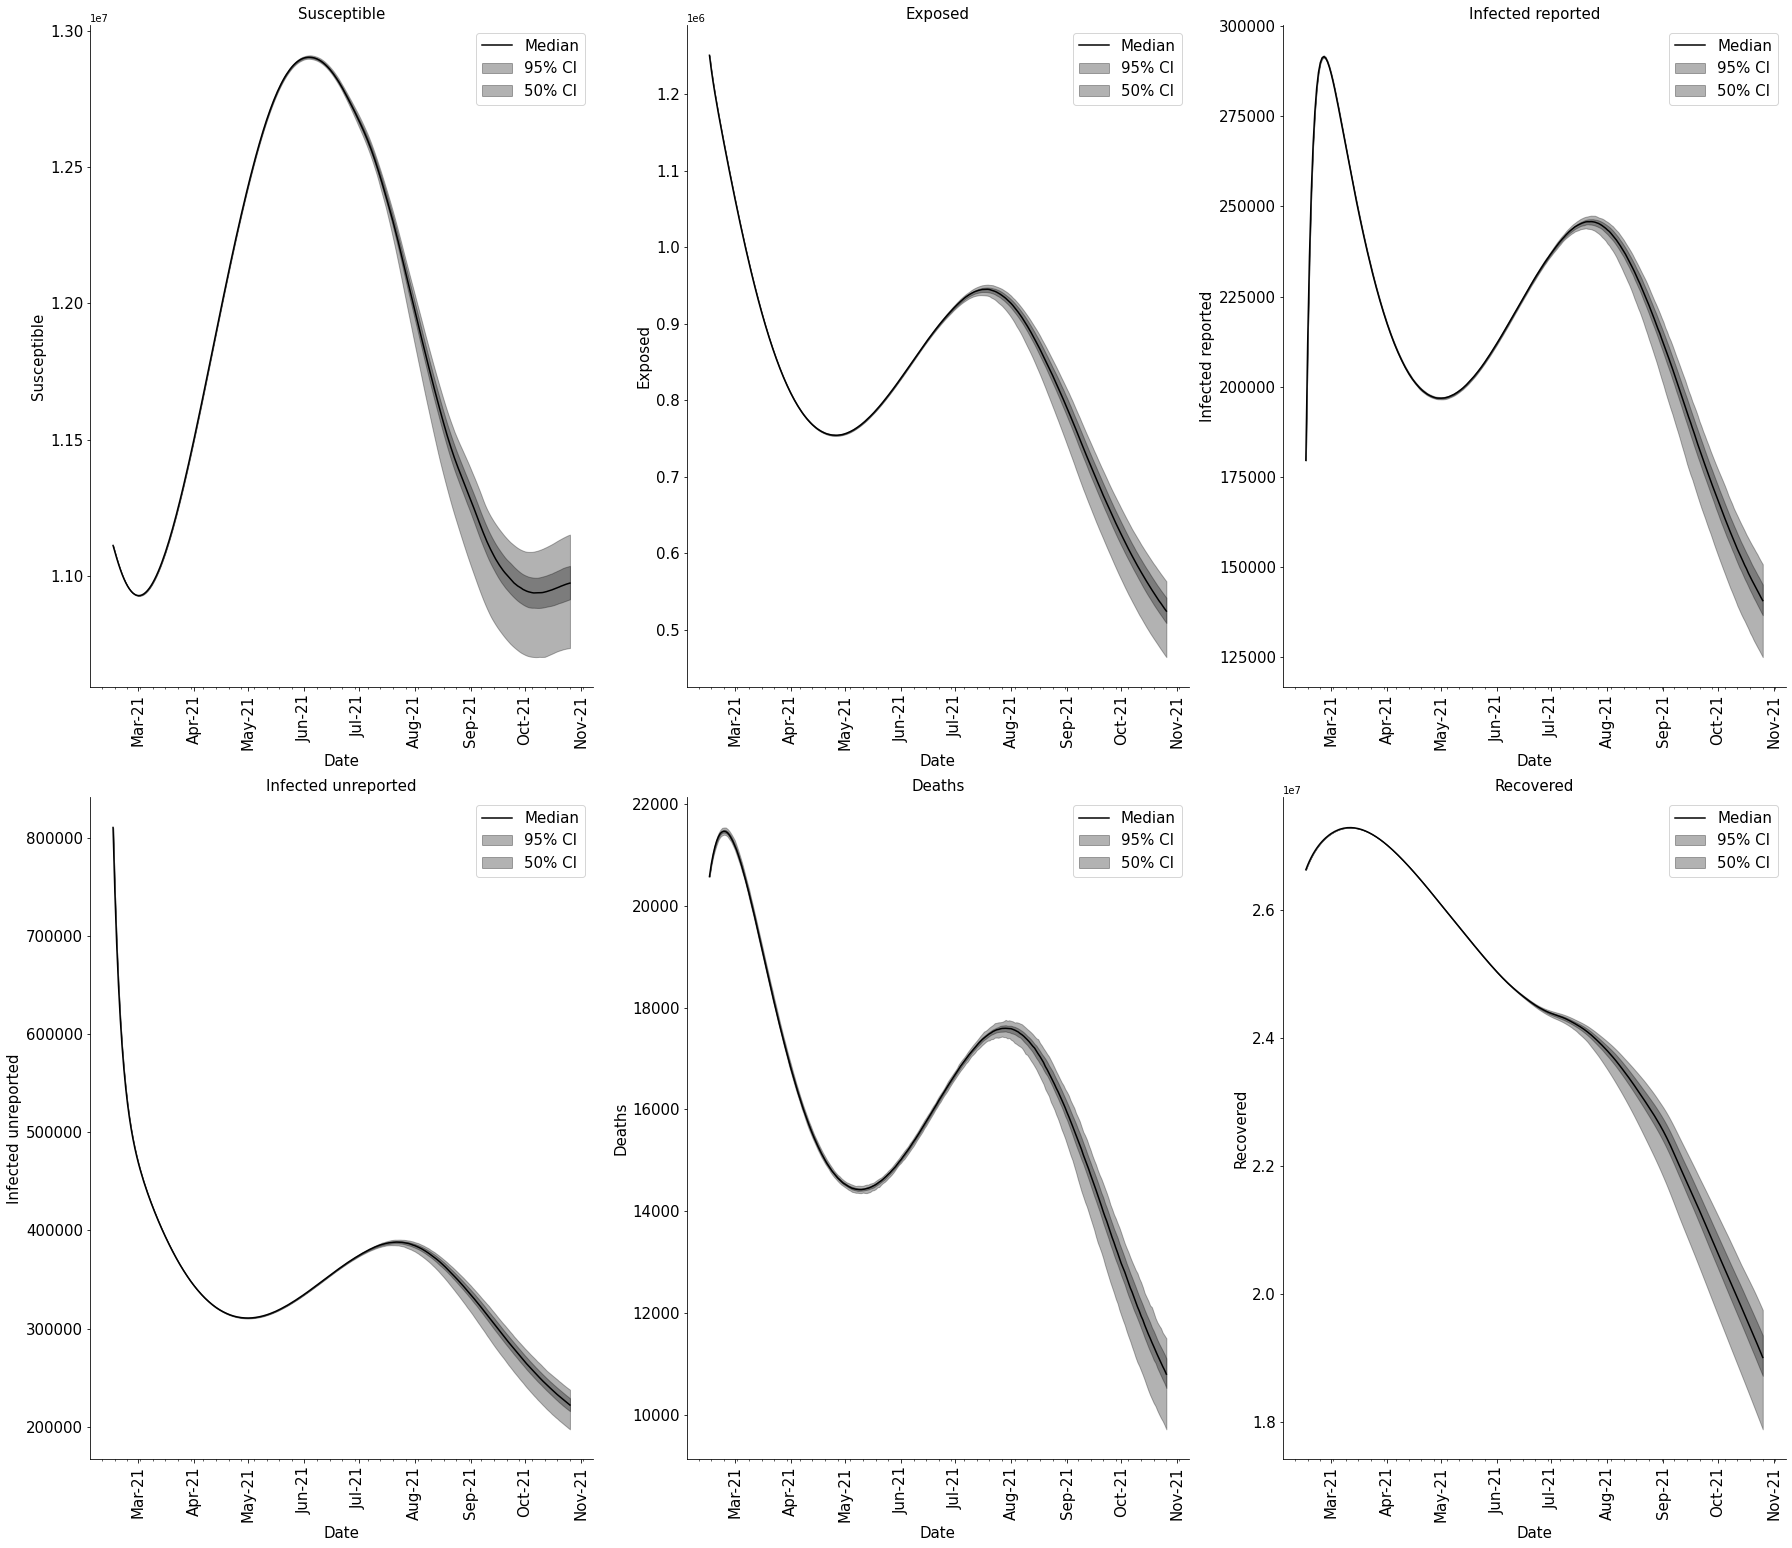

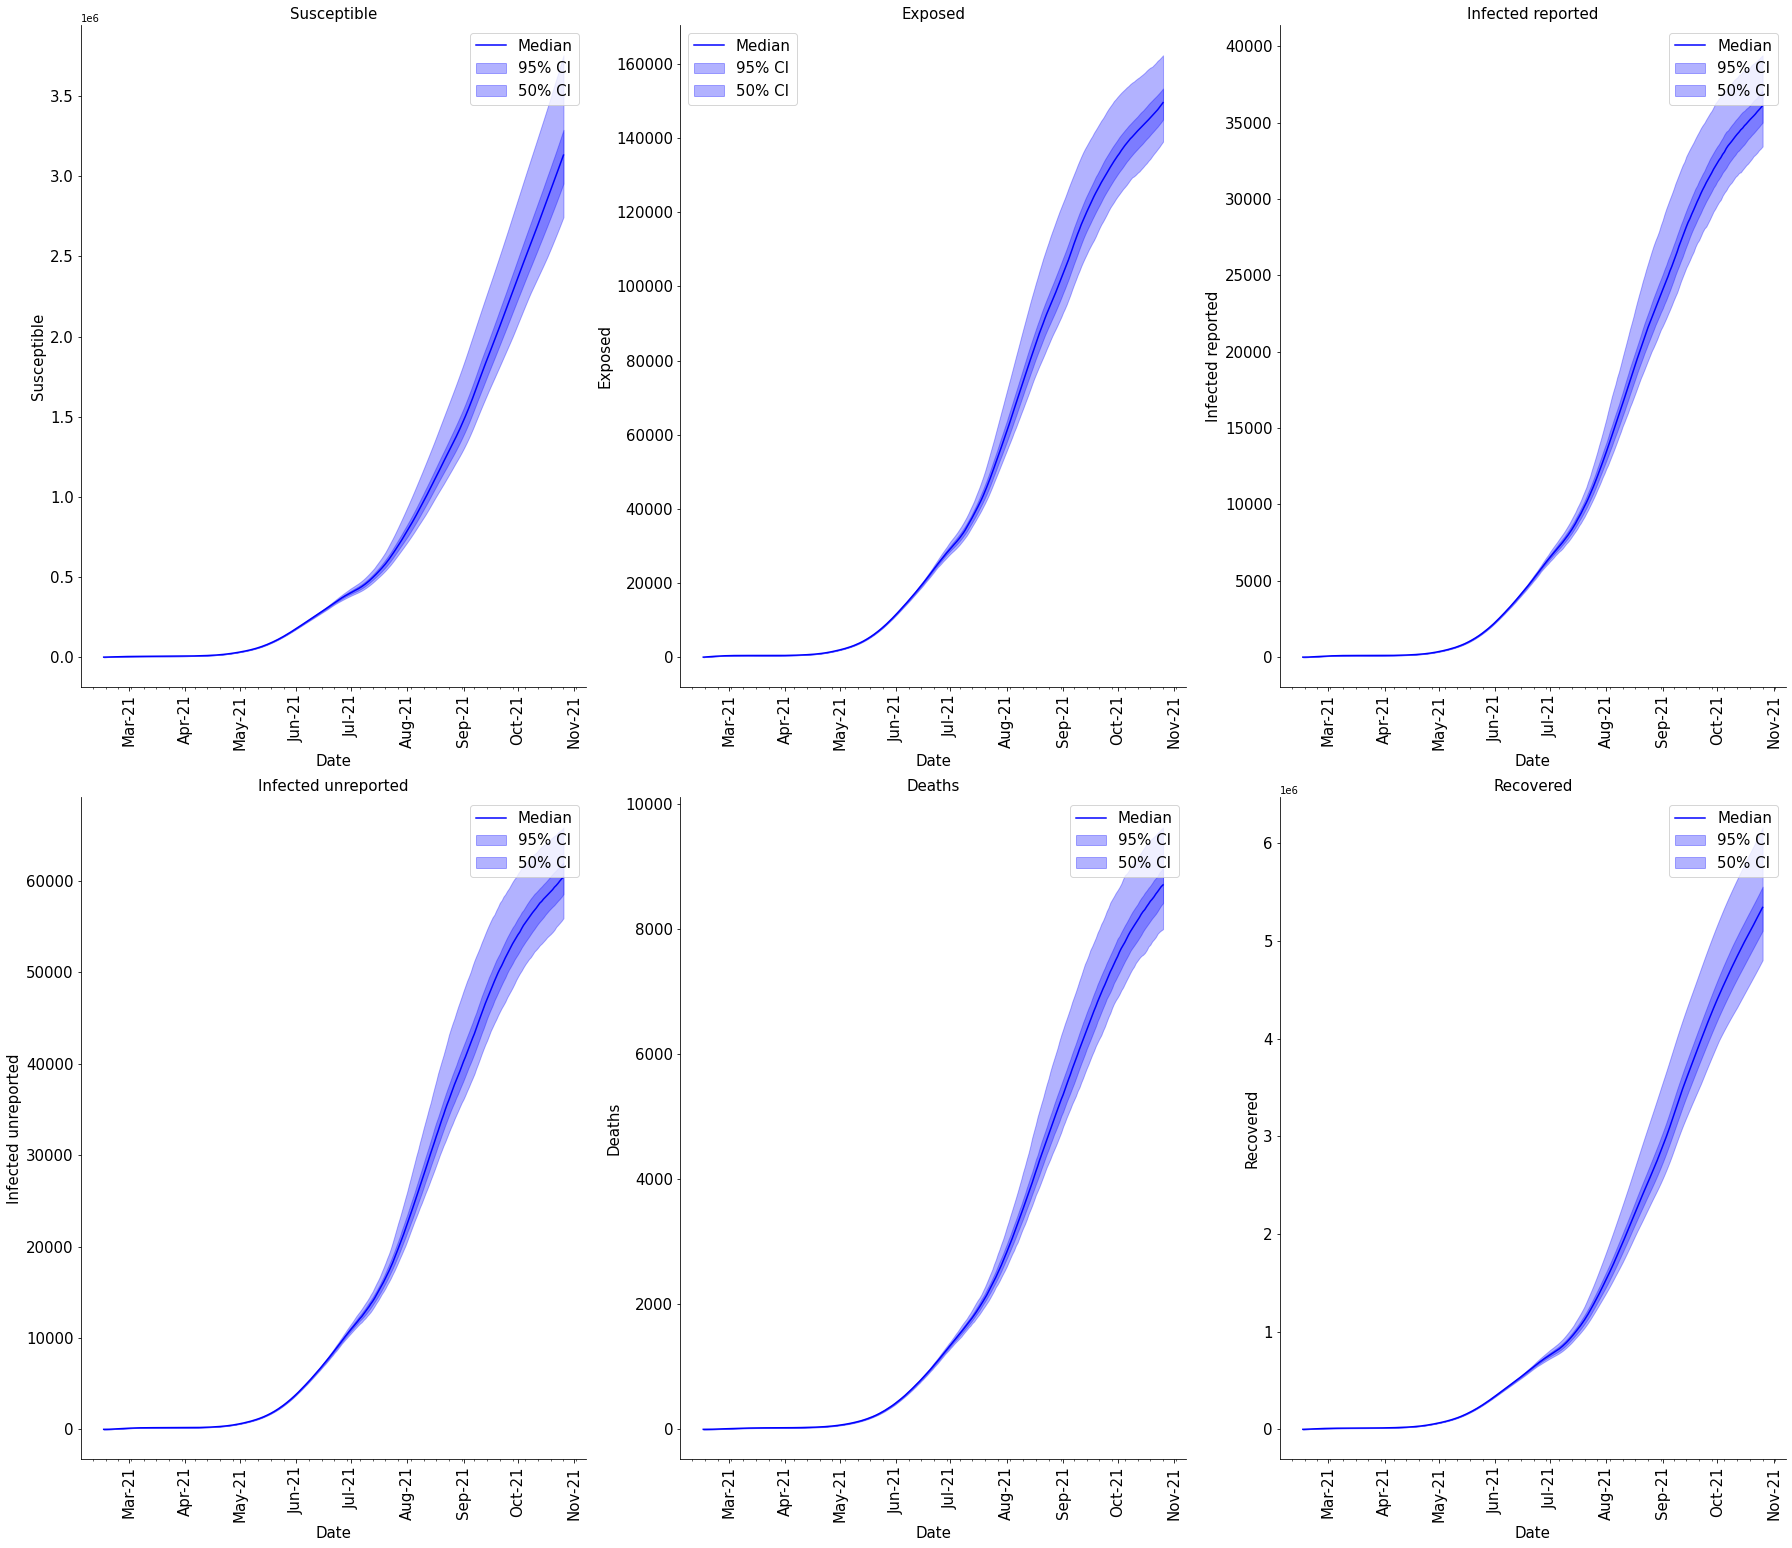

In [8]:
S_time = np.mean(df_all[0,:,:,:], -1)
E_time = np.mean(df_all[1,:,:,:], -1)
Ir_time = np.mean(df_all[2,:,:,:], -1)
Iu_time = np.mean(df_all[3,:,:,:], -1)
Ih_time = np.mean(df_all[4,:,:,:], -1)
R_time = np.mean(df_all[5,:,:,:], -1)
C_time = np.mean(df_all[6,:,:,:], -1)
D_time = np.mean(df_all[7,:,:,:], -1)

df_S  = create_df_response(S_time, time=num_steps, dates =dates)
df_E  = create_df_response(E_time, time=num_steps, dates =dates)
df_Ir  = create_df_response(Ir_time, time=num_steps, dates =dates)
df_Iu  = create_df_response(Iu_time, time=num_steps, dates =dates)
df_Ih  = create_df_response(Ih_time, time=num_steps, dates =dates)
df_R  = create_df_response(R_time, time=num_steps, dates =dates)
df_C  = create_df_response(C_time, time=num_steps, dates =dates)
df_D  = create_df_response(D_time, time=num_steps, dates =dates)

#---------------------------------------------------------------

fig, ax = plt.subplots(2, 3, figsize=(25, 21.6))

ax[0,0].plot(df_S.index.values, df_S["median"], color='k', label='Median')
ax[0,0].fill_between(df_S.index.values, df_S["high_95"], df_S["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,0].fill_between(df_S.index.values, df_S["high_50"], df_S["low_50"], color='k', alpha=0.3, label='50% CI')

ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,0].tick_params( which='both', axis='both', labelsize=15)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)

ax[0,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,0].set_xlabel("Date", fontsize=15)
ax[0,0].set_ylabel("Susceptible", fontsize=15)
ax[0,0].set_title("Susceptible", fontsize=15)
ax[0,0].legend(fontsize=15, loc='best')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,1].plot(df_E.index.values, df_E["median"], color='k', label='Median')
ax[0,1].fill_between(df_E.index.values, df_E["high_95"], df_E["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,1].fill_between(df_E.index.values, df_E["high_50"], df_E["low_50"], color='k', alpha=0.3, label='50% CI')

ax[0,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,1].tick_params( which='both', axis='both', labelsize=15)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

ax[0,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,1].set_xlabel("Date", fontsize=15)
ax[0,1].set_ylabel("Exposed", fontsize=15)
ax[0,1].set_title("Exposed", fontsize=15)
ax[0,1].legend(fontsize=15, loc='best')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,2].plot(df_Ir.index.values, df_Ir["median"], color='k', label='Median')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_95"], df_Ir["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_50"], df_Ir["low_50"], color='k', alpha=0.3, label='50% CI')

ax[0,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,2].tick_params( which='both', axis='both', labelsize=15)
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)

ax[0,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,2].set_xlabel("Date", fontsize=15)
ax[0,2].set_ylabel("Infected reported", fontsize=15)
ax[0,2].set_title("Infected reported", fontsize=15)
ax[0,2].legend(fontsize=15, loc='best')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,0].plot(df_Iu.index.values, df_Iu["median"], color='k', label='Median')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_95"], df_Iu["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_50"], df_Iu["low_50"], color='k', alpha=0.3, label='50% CI')

ax[1,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,0].tick_params( which='both', axis='both', labelsize=15)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)

ax[1,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,0].set_xlabel("Date", fontsize=15)
ax[1,0].set_ylabel("Infected unreported", fontsize=15)
ax[1,0].set_title("Infected unreported", fontsize=15)
ax[1,0].legend(fontsize=15, loc='best')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,1].plot(df_Ih.index.values, df_Ih["median"], color='k', label='Median')
ax[1,1].fill_between(df_Ih.index.values, df_Ih["high_95"], df_Ih["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,1].fill_between(df_Ih.index.values, df_Ih["high_50"], df_Ih["low_50"], color='k', alpha=0.3, label='50% CI')

ax[1,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,1].tick_params( which='both', axis='both', labelsize=15)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)

ax[1,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,1].set_xlabel("Date", fontsize=15)
ax[1,1].set_ylabel("Deaths", fontsize=15)
ax[1,1].set_title("Deaths", fontsize=15)
ax[1,1].legend(fontsize=15, loc='best')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,2].plot(df_R.index.values, df_R["median"], color='k', label='Median')
ax[1,2].fill_between(df_R.index.values, df_R["high_95"], df_R["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,2].fill_between(df_R.index.values, df_R["high_50"], df_R["low_50"], color='k', alpha=0.3, label='50% CI')

ax[1,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,2].tick_params( which='both', axis='both', labelsize=15)
ax[1,2].spines['right'].set_visible(False)
ax[1,2].spines['top'].set_visible(False)

ax[1,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,2].set_xlabel("Date", fontsize=15)
ax[1,2].set_ylabel("Recovered", fontsize=15)
ax[1,2].set_title("Recovered", fontsize=15)
ax[1,2].legend(fontsize=15, loc='best')
plt.tight_layout()

S_time = np.mean(df_all[8,:,:,:], -1)
E_time = np.mean(df_all[9,:,:,:], -1)
Ir_time = np.mean(df_all[10,:,:,:], -1)
Iu_time = np.mean(df_all[11,:,:,:], -1)
Ih_time = np.mean(df_all[12,:,:,:], -1)
R_time = np.mean(df_all[13,:,:,:], -1)
C_time = np.mean(df_all[14,:,:,:], -1)
D_time = np.mean(df_all[15,:,:,:], -1)

df_S  = create_df_response(S_time, time=num_steps, dates =dates)
df_E  = create_df_response(E_time, time=num_steps, dates =dates)
df_Ir  = create_df_response(Ir_time, time=num_steps, dates =dates)
df_Iu  = create_df_response(Iu_time, time=num_steps, dates =dates)
df_Ih  = create_df_response(Ih_time, time=num_steps, dates =dates)
df_R  = create_df_response(R_time, time=num_steps, dates =dates)
df_C  = create_df_response(C_time, time=num_steps, dates =dates)
df_D  = create_df_response(D_time, time=num_steps, dates =dates)

#---------------------------------------------------------------

fig, ax = plt.subplots(2, 3, figsize=(25, 21.6))

ax[0,0].plot(df_S.index.values, df_S["median"], color='b', label='Median')
ax[0,0].fill_between(df_S.index.values, df_S["high_95"], df_S["low_95"], color='b', alpha=0.3, label='95% CI')
ax[0,0].fill_between(df_S.index.values, df_S["high_50"], df_S["low_50"], color='b', alpha=0.3, label='50% CI')

ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,0].tick_params( which='both', axis='both', labelsize=15)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)

ax[0,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,0].set_xlabel("Date", fontsize=15)
ax[0,0].set_ylabel("Susceptible", fontsize=15)
ax[0,0].set_title("Susceptible", fontsize=15)
ax[0,0].legend(fontsize=15, loc='best')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,1].plot(df_E.index.values, df_E["median"], color='b', label='Median')
ax[0,1].fill_between(df_E.index.values, df_E["high_95"], df_E["low_95"], color='b', alpha=0.3, label='95% CI')
ax[0,1].fill_between(df_E.index.values, df_E["high_50"], df_E["low_50"], color='b', alpha=0.3, label='50% CI')

ax[0,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,1].tick_params( which='both', axis='both', labelsize=15)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

ax[0,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,1].set_xlabel("Date", fontsize=15)
ax[0,1].set_ylabel("Exposed", fontsize=15)
ax[0,1].set_title("Exposed", fontsize=15)
ax[0,1].legend(fontsize=15, loc='best')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,2].plot(df_Ir.index.values, df_Ir["median"], color='b', label='Median')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_95"], df_Ir["low_95"], color='b', alpha=0.3, label='95% CI')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_50"], df_Ir["low_50"], color='b', alpha=0.3, label='50% CI')

ax[0,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,2].tick_params( which='both', axis='both', labelsize=15)
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)

ax[0,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,2].set_xlabel("Date", fontsize=15)
ax[0,2].set_ylabel("Infected reported", fontsize=15)
ax[0,2].set_title("Infected reported", fontsize=15)
ax[0,2].legend(fontsize=15, loc='best')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,0].plot(df_Iu.index.values, df_Iu["median"], color='b', label='Median')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_95"], df_Iu["low_95"], color='b', alpha=0.3, label='95% CI')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_50"], df_Iu["low_50"], color='b', alpha=0.3, label='50% CI')

ax[1,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,0].tick_params( which='both', axis='both', labelsize=15)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)

ax[1,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,0].set_xlabel("Date", fontsize=15)
ax[1,0].set_ylabel("Infected unreported", fontsize=15)
ax[1,0].set_title("Infected unreported", fontsize=15)
ax[1,0].legend(fontsize=15, loc='best')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,1].plot(df_Ih.index.values, df_Ih["median"], color='b', label='Median')
ax[1,1].fill_between(df_Ih.index.values, df_Ih["high_95"], df_Ih["low_95"], color='b', alpha=0.3, label='95% CI')
ax[1,1].fill_between(df_Ih.index.values, df_Ih["high_50"], df_Ih["low_50"], color='b', alpha=0.3, label='50% CI')

ax[1,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,1].tick_params( which='both', axis='both', labelsize=15)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)

ax[1,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,1].set_xlabel("Date", fontsize=15)
ax[1,1].set_ylabel("Deaths", fontsize=15)
ax[1,1].set_title("Deaths", fontsize=15)
ax[1,1].legend(fontsize=15, loc='best')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,2].plot(df_R.index.values, df_R["median"], color='b', label='Median')
ax[1,2].fill_between(df_R.index.values, df_R["high_95"], df_R["low_95"], color='b', alpha=0.3, label='95% CI')
ax[1,2].fill_between(df_R.index.values, df_R["high_50"], df_R["low_50"], color='b', alpha=0.3, label='50% CI')

ax[1,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,2].tick_params( which='both', axis='both', labelsize=15)
ax[1,2].spines['right'].set_visible(False)
ax[1,2].spines['top'].set_visible(False)

ax[1,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,2].set_xlabel("Date", fontsize=15)
ax[1,2].set_ylabel("Recovered", fontsize=15)
ax[1,2].set_title("Recovered", fontsize=15)
ax[1,2].legend(fontsize=15, loc='best')
plt.tight_layout()

array([40008973.62089056, 40008973.62089057, 40008973.62060282,
       40008973.61994167, 40008973.61884022, 40008973.61723153,
       40008973.61503972, 40008973.6121747 , 40008973.60852825,
       40008973.60397007, 40008973.59834339, 40008973.59146012,
       40008973.58309478, 40008973.57297754, 40008973.56078572,
       40008973.546134  , 40008973.52856223, 40008973.50752135,
       40008973.4823565 , 40008973.45228674, 40008973.41638096,
       40008973.3735294 , 40008973.32240922, 40008973.26144406,
       40008973.18875537, 40008973.10210481, 40008972.99882527,
       40008972.87573901, 40008972.72905979, 40008972.55427681,
       40008972.34601568, 40008972.09787361, 40008971.80222243,
       40008971.44997425, 40008971.03030221, 40008970.5303079 ,
       40008969.93462495, 40008969.22494705, 40008968.37946563,
       40008967.37219999, 40008966.17219945, 40008964.7425929 ,
       40008963.03945687, 40008961.01046734, 40008958.59329396,
       40008955.71368793, 40008952.28320